In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Read in data

In [2]:
hormone_data = pd.read_csv('hormone_data.csv')

In [3]:
hormone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
lot       27 non-null object
hrs       27 non-null int64
amount    27 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 776.0+ bytes


In [4]:
hormone_data.head()

,lot,hrs,amount
0,A,99,25.8
1,A,152,20.5
2,A,293,14.3
3,A,155,23.2
4,A,196,20.6


In [5]:
hormone_data.tail()

,lot,hrs,amount
22,C,58,32.8
23,C,49,32.5
24,C,150,25.4
25,C,107,31.7
26,C,125,28.5


In [6]:
hormone_data.describe(include='all')

,lot,hrs,amount
count,27,27.000000,27.000000
unique,3,NaN,NaN
top,C,NaN,NaN
freq,9,NaN,NaN
mean,NaN,165.000000,24.692593
std,NaN,104.475246,6.438521
min,NaN,29.000000,11.600000
25%,NaN,93.500000,20.750000
50%,NaN,151.000000,25.800000
75%,NaN,192.000000,30.050000


In [7]:
for lot in hormone_data.lot.unique():
    print(f'lot {lot} means')
    print(hormone_data[hormone_data.lot==lot].mean())
    print()

lot A means
hrs       150.555556
amount     23.077778
dtype: float64

lot B means
hrs       233.444444
amount     22.077778
dtype: float64

lot C means
hrs       111.000000
amount     28.922222
dtype: float64



# Plot Data

Text(0.5, 1.0, 'Hormone Data')

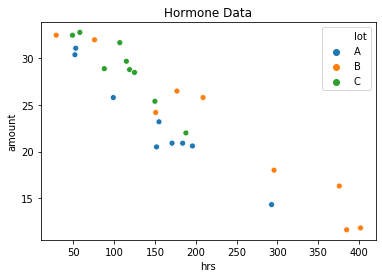

In [8]:
sns.scatterplot(x='hrs',y='amount', hue='lot', data=hormone_data)
plt.title("Hormone Data")

# Least-Squares Regression

In [16]:
def convert_z_to_c(z):
    # create c_i = (1, z_i) matrix
    c = np.ones((len(z),2))
    c[:,1] = z
    return c

def find_beta_linalg(z, y):
    c = convert_z_to_c(z)
    CtC = c.T.dot(c) # inner-product matrix
    beta = np.linalg.inv(CtC).dot(c.T.dot(y))
    return beta


In [10]:
for lot in hormone_data.lot.unique():
    lot_data = hormone_data[hormone_data.lot == lot]
    print(f"regression fit for lot {lot}")
    print(find_beta_linalg(lot_data.hrs, lot_data.amount))
    print()

regression fit for lot A
[33.36005531 -0.06829557]

regression fit for lot B
[35.22982495 -0.05633909]

regression fit for lot C
[37.1936709  -0.07451756]



In [17]:
print(f"regression fit for all data")
beta = find_beta_linalg(hormone_data.hrs, hormone_data.amount)
print(beta)

regression fit for all data
[34.17204585 -0.05745123]


# Standard Error

In [12]:
def RSE(z, y, b):
    c = convert_z_to_c(z)
    return np.sum([(yi-ci.dot(b))**2 for yi, ci in zip(y,c)])

def find_Ginv(z):
    c = convert_z_to_c(z)
    G = c.T.dot(c)
    Ginv = np.linalg.inv(G)
    return Ginv

def find_se_hat(z, y, beta):
    s_f_hat = (RSE(z, y, beta)/len(y))**0.5
    Ginv = find_Ginv(z)
    se_b0 = s_f_hat*np.sqrt(Ginv[0,0])
    se_b1 = s_f_hat*np.sqrt(Ginv[1,1])
    return se_b0, se_b1

def find_se_bar(z, y, beta):
    c = convert_z_to_c(z)
    s_f_bar = (RSE(z, y, beta)/(len(y)-c.shape[1]))**0.5
    Ginv = find_Ginv(z)
    se_b0 = s_f_bar*np.sqrt(Ginv[0,0])
    se_b1 = s_f_bar*np.sqrt(Ginv[1,1])
    return se_b0, se_b1

In [13]:
seh_b0, seh_b1 = find_se_hat(hormone_data.hrs, hormone_data.amount, beta)
seb_b0, seb_b1 = find_se_bar(hormone_data.hrs, hormone_data.amount, beta)
print(f"b0_h = {beta[0]:.2f}")
print(f"b1_h = {beta[1]:.4f}")
print(f"seh_b0 = {seh_b0:.2f}")
print(f"seb_b0 = {seb_b0:.2f}")
print(f"seh_b1 = {seh_b1:.4f}")
print(f"seb_b1 = {seb_b1:.4f}")

b0_h = 34.17
b1_h = -0.0575
seh_b0 = 0.83
seb_b0 = 0.87
seh_b1 = 0.0043
seb_b1 = 0.0045


# Bootstrap the residuals

In [14]:
def get_errors(z, y, beta):
    c = convert_z_to_c(z)
    e = y-c.dot(beta)
    return e

def bootstrap_errors_to_y_star(z, beta, e):
    c = convert_z_to_c(z)
    e_star = np.random.choice(e, len(e))
    y_star = c.dot(beta)+e_star
    return e_star, y_star

In [15]:
y = hormone_data.amount
z = hormone_data.hrs
e = get_errors(z,y,beta)
e_star, y_star = bootstrap_errors_to_y_star(z, beta, e)
beta_star = find_beta_linalg(z, y_star)

seh_b0,seh_b1 = find_se_hat(z, y_star, beta_star)
seb_b0,seb_b1 = find_se_bar(z, y_star, beta_star)
print(f"b0_h = {beta_star[0]:.2f}")
print(f"b1_h = {beta_star[1]:.4f}")
print(f"seh_b0 = {seh_b0:.2f}")
print(f"seb_b0 = {seb_b0:.2f}")
print(f"seh_b1 = {seh_b1:.4f}")
print(f"seb_b1 = {seb_b1:.4f}")

b0_h = 33.03
b1_h = -0.0513
seh_b0 = 0.91
seb_b0 = 0.95
seh_b1 = 0.0047
seb_b1 = 0.0049


# Generate some random numbers